# Fraud Detection ML Model

## Table of Contents

#### Introduction <a class='anchor' id='1'></a>
In this project, we develop a binary classification Machine Learning model for fraud detection.

We will be using a dataset from the IEEE-CIS Fraud Detection competition from 2019.

#### Dataset <a class='anchor' id='2'></a>

The data is broken into two files ***identity*** and ***transaction***, which are joined by ***TransactionID***.

The binary target =  ***isFraud***, where 0 = not fraud, 1 = fraud.

In [22]:
#import libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import accuracy_score, precision_score, recall_score

import catboost as ctb

#### Exploratory Data Analysis <a class='anchor' id='3'></a>

In [23]:
#Import datasets
train_identity = pd.read_csv("D:\\Finance Portfolio\\train_identity.csv")
train_transaction = pd.read_csv("D:\\Finance Portfolio\\train_transaction.csv")

test_identity = pd.read_csv("D:\\Finance Portfolio\\test_identity.csv")
test_transaction = pd.read_csv("D:\\Finance Portfolio\\test_transaction.csv")

In [24]:
#Explore target
train_transaction['isFraud'].value_counts(normalize=True)

isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

Only 3.5% of transaction were cases of fraud.

In [25]:
print(f'train_transaction shape: {train_transaction.shape}')
print(f'train_identity shape: {train_identity.shape}')
print()
print(f'test_transaction shape: {test_transaction.shape}')
print(f'test_identity shape: {test_identity.shape}')

train_transaction shape: (590540, 394)
train_identity shape: (144233, 41)

test_transaction shape: (506691, 393)
test_identity shape: (141907, 41)


The transaction sets have 394 columns - TransactionID, isFraud, TransactionDT, TransactionAmt, ProductCD, card1 to card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1 to C14, D1 to D15, M1 to M9, V1 to V339.

The test_transaction set has the isFraud column removed. Thus, for our own learning purposes we wont be using the test sets as this was for the competition. We will need to create separate test and validation sets from the training sets.

The identity sets have 41 columns - TransactionID, id_01 to id_38, DeviceType, and DeviceInfo.

The sheer number of potential predictors is staggering. The obscurity of what each predictor may mean also makes it difficult for determining which predictor to include into the model.

In [26]:
train_transaction.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0    NaN  150.0    discover  142.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  404.0  150.0  mastercard  102.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  490.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  567.0  150.0  mastercard  117.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  514.0  150.0  mastercard  102.0  ...  0.0   0.0   0.0   0.0   0.0  0.0   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  0.0   0.0   0.0   0.0  

[5 rows x 394 columns]

In [27]:
train_identity.head(5)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [28]:
train_transaction.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 394, dtype: int64

In [29]:
train_identity.isnull().sum()

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

There is a lot of NaN values to address, which we may try imputation methods or select classification models such as decision tree classifier or XGBoost. But let's try and find some correlation between the predictors to see if we can group similar predictors, or if predictors have low correlation to the target - we may potentially remove them.

In [30]:
#Let's merge before we do correlation analysis
merge = train_transaction.merge(train_identity, how='left', on='TransactionID')
merge.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [31]:
merge.shape

(590540, 434)

#### Categorical data

In [32]:
#Isolate categorical data
categorical = merge.select_dtypes(include='object')
for x in categorical.columns:
    print(x)

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo


In [33]:
categorical.info() #The data types are all string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ProductCD      590540 non-null  object
 1   card4          588963 non-null  object
 2   card6          588969 non-null  object
 3   P_emaildomain  496084 non-null  object
 4   R_emaildomain  137291 non-null  object
 5   M1             319440 non-null  object
 6   M2             319440 non-null  object
 7   M3             319440 non-null  object
 8   M4             309096 non-null  object
 9   M5             240058 non-null  object
 10  M6             421180 non-null  object
 11  M7             244275 non-null  object
 12  M8             244288 non-null  object
 13  M9             244288 non-null  object
 14  id_12          144233 non-null  object
 15  id_15          140985 non-null  object
 16  id_16          129340 non-null  object
 17  id_23          5169 non-null    object
 18  id_2

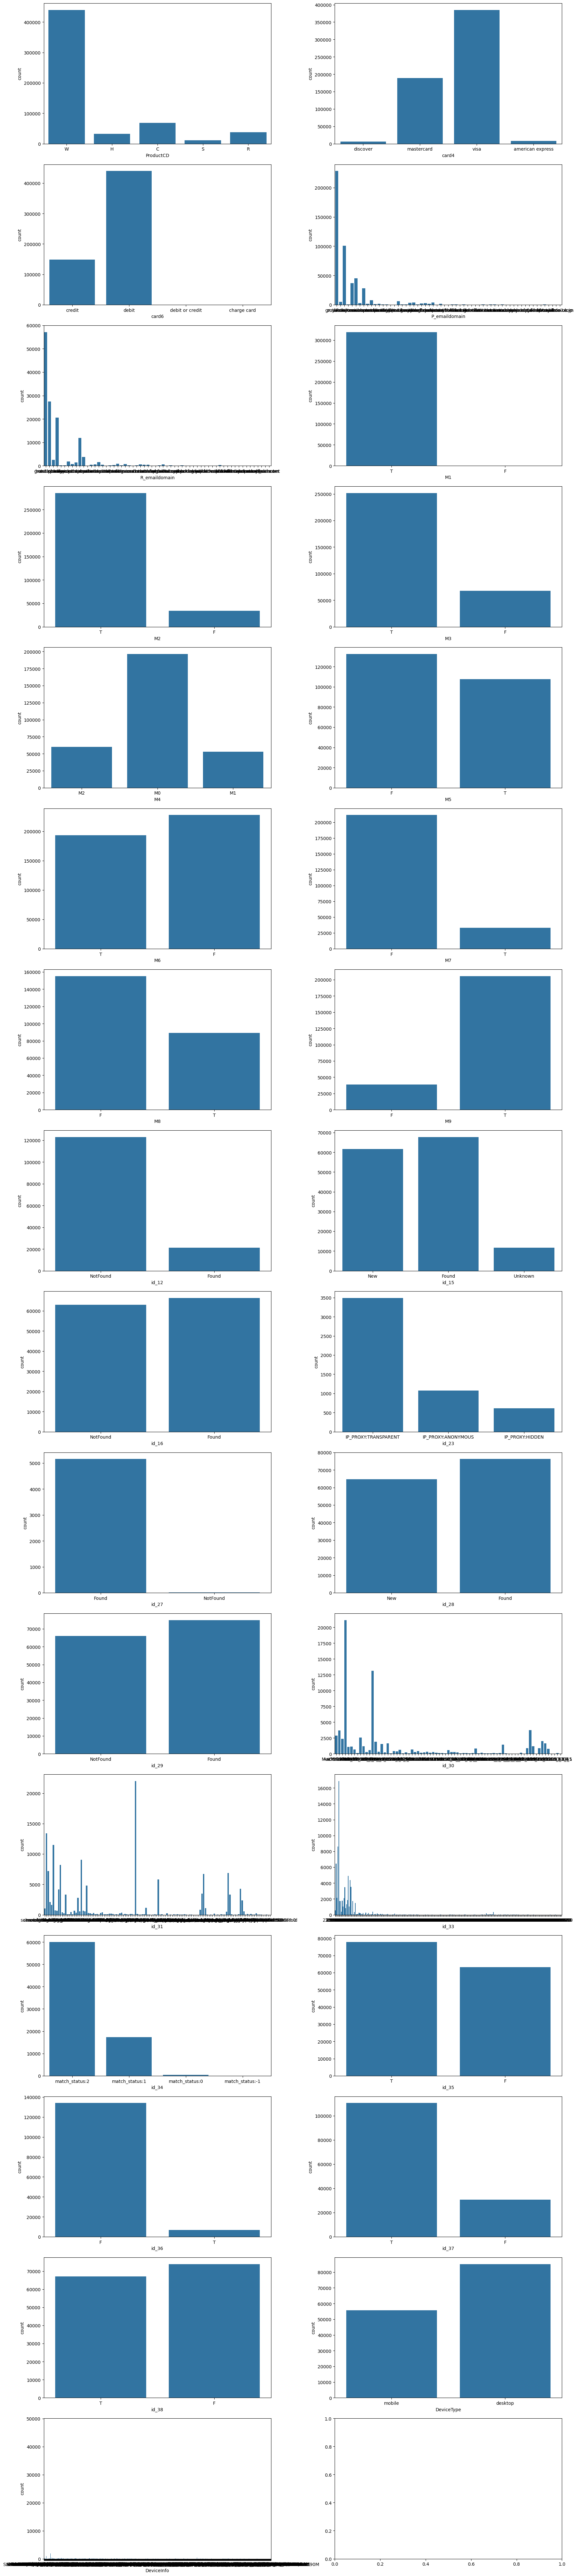

In [34]:
fig, axes = plt.subplots(nrows=16, ncols=2, figsize=(18,80))
flat_axes = axes.flatten()
for i, ax in enumerate(flat_axes):
        if i == 31:
                break
        else:
                sns.countplot(x=categorical.iloc[:,i], ax=ax)
fig.tight_layout()
plt.show()

#### Split into training, validation, and testing sets

In [35]:
X = merge.drop('isFraud', axis=1)
y = merge['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #20% testing set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #20% validation set

In [36]:
X_train.shape

(377945, 433)

#### Normalize Data

In [37]:
scaler = StandardScaler()
numeric = X_train.select_dtypes(exclude='object') #Remove non-numeric data first
X_train_scaled = scaler.fit_transform(numeric) #Normalize data
numeric_X = pd.DataFrame(X_train_scaled, columns=numeric.columns)

In [38]:
numeric.shape

(377945, 402)

#### Feature Engineering - Correlational Analysis

In [39]:
#Let's look at the numeric data
for x in numeric_X.columns:
    print(x)

TransactionID
TransactionDT
TransactionAmt
card1
card2
card3
card5
addr1
addr2
dist1
dist2
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167
V168
V169
V170
V171
V172
V173
V174
V175
V176
V177
V178
V179
V180
V181
V182
V183
V184

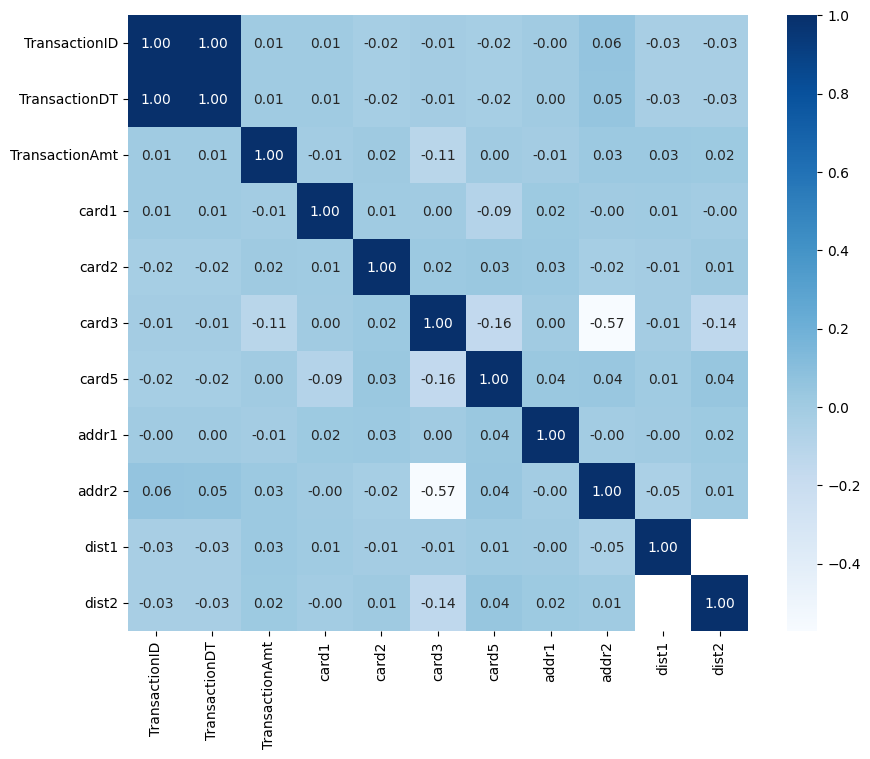

In [40]:
#Correlation for first few columns
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(numeric_X.iloc[:,0:11].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.show()

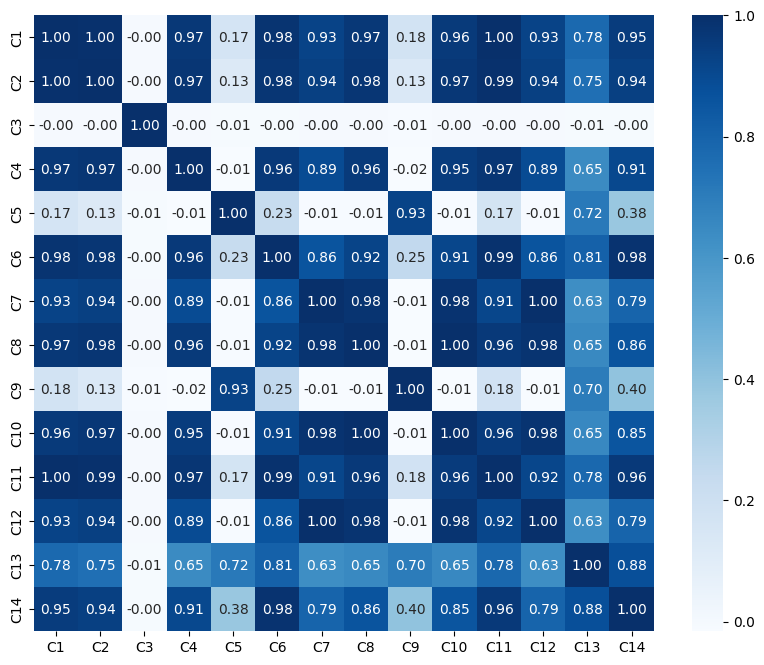

In [41]:
#C1-C14 Correlation
C_column = [f'C{c}' for c in range(1,15)]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(numeric_X[C_column].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.show()

There seem to be a lot of redundancy - ie C1 + C2 have perfect correlation, C1 + C11 have perfect correlation. We will drop any redundant column with correlation >0.9.

In [43]:
threshold = 0.8
to_remove = []
corr_matrix = numeric_X[C_column].corr()
mask = (corr_matrix >= 0.8) & (corr_matrix < 1)
upper_tri_mask = np.triu(np.ones_like(mask, dtype=bool))
mask = mask & upper_tri_mask 
column_names = mask.stack().reset_index(name='correlation').query('correlation > @threshold')['level_1']
to_remove = list(column_names.unique())
C_column_reduced = [item for item in C_column if item not in to_remove]

In [44]:
print(C_column_reduced) #We are left with 3 predictors.

['C1', 'C3', 'C5']


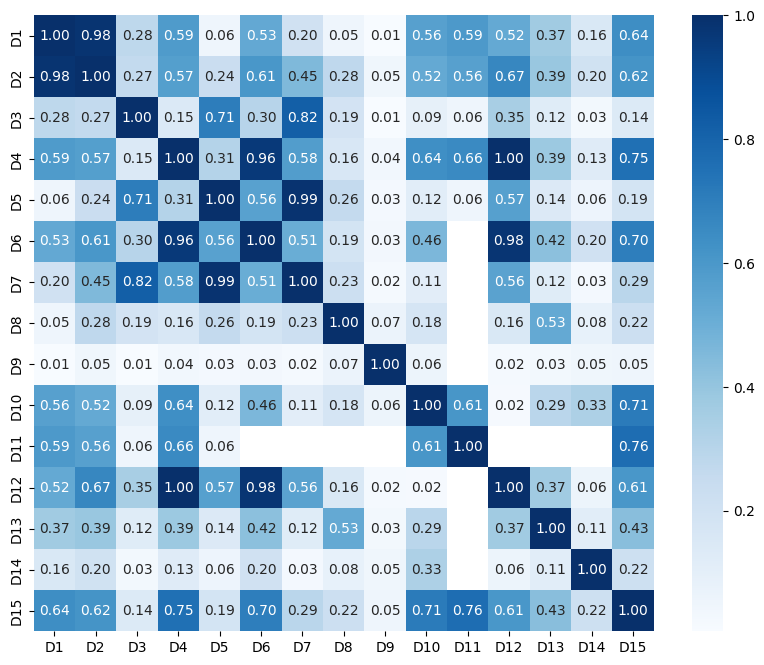

In [45]:
#D1-D15 Correlation
D_column = [f'D{d}' for d in range(1,16)]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(numeric_X[D_column].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.show()

D1 + D2 have near perfect linear correlation. D12, D4, D6 have near perfect correlation.

In [46]:
to_remove = []
corr_matrix = numeric_X[D_column].corr()
mask = (corr_matrix >= 0.8) & (corr_matrix < 1)
upper_tri_mask = np.triu(np.ones_like(mask, dtype=bool))
mask = mask & upper_tri_mask 
column_names = mask.stack().reset_index(name='correlation').query('correlation > @threshold')['level_1']
to_remove = list(column_names.unique())
D_column_reduced = [item for item in D_column if item not in to_remove]

In [47]:
print(D_column_reduced)

['D1', 'D3', 'D4', 'D5', 'D8', 'D9', 'D10', 'D11', 'D13', 'D14', 'D15']


Now we'll impute missing data so we can perform PCA.

In [48]:
#Impute using column average
for x in D_column_reduced:
    numeric_X[x] = numeric_X[x].fillna(numeric_X[x].mean())

In [49]:
#PCA to reduce dimensionality
pca = PCA(n_components=5)
pca.fit(numeric_X[D_column_reduced])
transformed_D = pca.transform(numeric_X[D_column_reduced])
column_names = [f'D{x}' for x in range(0,5)]
transformed_D_df = pd.DataFrame(transformed_D, columns=column_names)
transformed_D_df

D0        D1        D2        D3        D4
0       4.260817 -0.414896 -0.587854 -0.019703 -0.294151
1       0.288041  0.048749 -2.793186 -0.666341 -0.483596
2      -1.412147 -0.527583 -0.201826 -0.110987  0.324761
3      -1.067035 -0.185454  0.281211 -0.483145 -0.034839
4       0.527976 -0.987447  0.491623  0.666311  0.623788
...          ...       ...       ...       ...       ...
377940 -0.281295 -0.016890  0.483899  0.152639  0.124413
377941 -1.404105 -0.522066 -0.200769 -0.113348  0.296499
377942  2.099036 -0.762407 -0.226549 -0.151628 -0.019953
377943  1.854395  0.135080 -1.800961 -0.240952 -0.142752
377944 -0.296240 -0.047777  0.444780  0.118257  0.170923

[377945 rows x 5 columns]

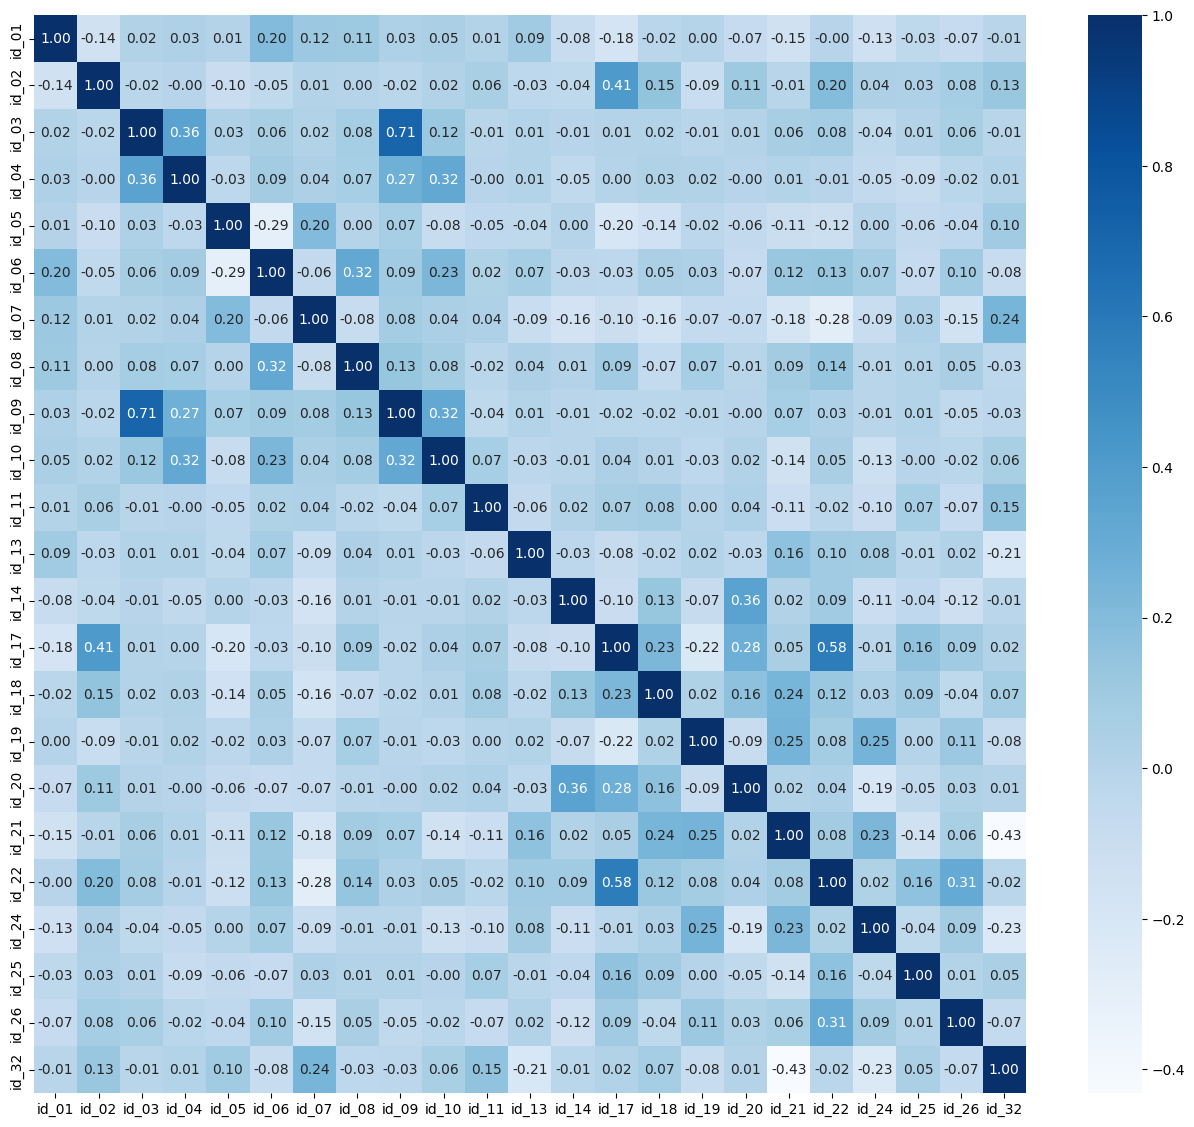

In [50]:
#id_ correlation
id_column = [id for id in numeric_X.columns if 'id' in id]
fig, ax = plt.subplots(figsize=(16,14))
sns.heatmap(numeric_X[id_column].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.show()

Doesn't look like there's any redundancy here.

In [51]:
#Impute using column average
for x in id_column:
    numeric_X[x] = numeric_X[x].fillna(numeric_X[x].mean())

#PCA to reduce dimensionality
pca = PCA(n_components=5)
pca.fit(numeric_X[id_column])
column_names = [f'id{x}' for x in range(0,5)]
transformed_id = pca.transform(numeric_X[id_column])
transformed_id_df = pd.DataFrame(transformed_id, columns=column_names)
transformed_id_df

id0           id1           id2           id3           id4
0      -4.264119e-18  3.593821e-18  8.208498e-18  1.298201e-17 -6.342207e-18
1      -4.264119e-18  3.593821e-18  8.208498e-18  1.298201e-17 -6.342207e-18
2      -1.662171e-01 -4.174839e-01  1.183952e+00 -4.162464e-01 -1.199775e+00
3      -4.264119e-18  3.593821e-18  8.208498e-18  1.298201e-17 -6.342207e-18
4      -4.264119e-18  3.593821e-18  8.208498e-18  1.298201e-17 -6.342207e-18
...              ...           ...           ...           ...           ...
377940  5.777009e-02  3.190241e+00 -3.018969e-01  1.762535e-01  1.630116e+00
377941 -4.264119e-18  3.593821e-18  8.208498e-18  1.298201e-17 -6.342207e-18
377942 -4.264119e-18  3.593821e-18  8.208498e-18  1.298201e-17 -6.342207e-18
377943 -4.264119e-18  3.593821e-18  8.208498e-18  1.298201e-17 -6.342207e-18
377944 -1.772718e+00  1.514194e+00 -3.191352e+00  6.012516e+00 -2.282656e+00

[377945 rows x 5 columns]

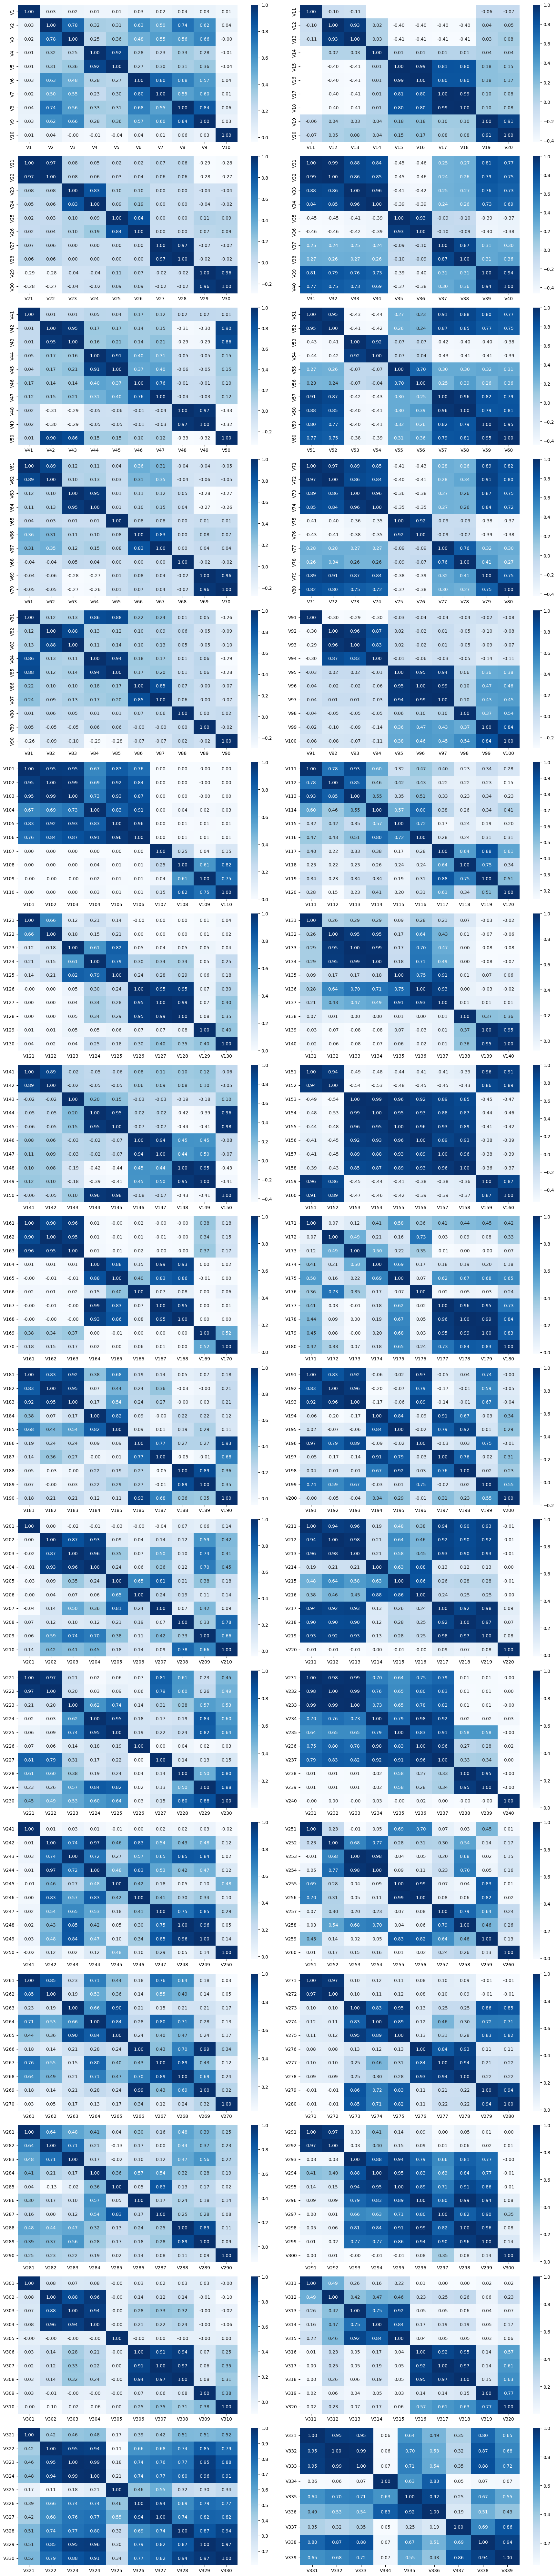

In [52]:
#V columns - because the V column is so large, we will break it down into groups for evaluation.
V_column = [V for V in numeric_X.columns if 'V' in V]
fig, axes = plt.subplots(nrows=17, ncols=2, figsize=(18,80))
flat_axes = axes.flatten()
start_col = 0
for i, ax in enumerate(flat_axes):
        if i == 33:
                end_col = 339
                corr_matrix = numeric_X[V_column[start_col:end_col]].corr()
                sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', ax=ax)
        else:
                end_col = ((i+1)*10)
                corr_matrix = numeric_X[V_column[start_col:end_col]].corr()
                sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.2f', ax=ax)
                start_col = end_col
fig.tight_layout()
plt.show()

In [53]:
#Dropping V_columns with high correlation at threshold >0.8
V_column = [V for V in numeric_X.columns if 'V' in V]
threshold = 0.8
start_col = 0
to_remove = []
for i in range(0,34):
        if i == 33:
                end_col = 339
                corr_matrix = numeric_X[V_column[start_col:end_col]].corr()

                mask = (corr_matrix >= 0.8) & (corr_matrix < 1)
                upper_tri_mask = np.triu(np.ones_like(mask, dtype=bool))
                mask = mask & upper_tri_mask 
                column_names = mask.stack().reset_index(name='correlation').query('correlation > @threshold')['level_1']
                to_remove += list(column_names.unique())
        else:
                end_col = ((i+1)*10)
                corr_matrix = numeric_X[V_column[start_col:end_col]].corr()

                mask = (corr_matrix >= 0.8) & (corr_matrix < 1)
                upper_tri_mask = np.triu(np.ones_like(mask, dtype=bool))
                mask = mask & upper_tri_mask 
                column_names = mask.stack().reset_index(name='correlation').query('correlation > @threshold')['level_1']
                to_remove += list(column_names.unique())

                start_col = end_col
V_column_removed = [item for item in V_column if item not in to_remove]
len(V_column_removed)

179

We manage to narrow down to 179 from 339. Let's put it through PCA.

In [54]:
#Impute using column average
for x in V_column_removed:
    numeric_X[x] = numeric_X[x].fillna(numeric_X[x].mean())

#PCA to reduce dimensionality
pca = PCA(n_components=15)
pca.fit(numeric_X[V_column_removed])
column_names = [f'V{x}' for x in range(0,15)]
transformed_V = pca.transform(numeric_X[V_column_removed])
transformed_V_df = pd.DataFrame(transformed_V, columns=column_names)
transformed_V_df

V0         V1        V2        V3        V4        V5        V6  \
0      -0.767033   1.596279 -1.554304 -0.446095  0.343564  2.444470  0.559075   
1       1.213665  -7.827753  0.851387  2.992259  5.747006 -1.073050 -4.212252   
2       1.440459 -17.086742  2.073834  0.990052  9.628768  0.384495 -5.906704   
3       3.748832   0.338195  8.426961  3.965504  3.309231 -2.641246  1.661616   
4      -0.604782   1.044326 -0.993140 -0.213416  1.435655  1.553320  0.134289   
...          ...        ...       ...       ...       ...       ...       ...   
377940 -0.293134  -0.699807 -0.089167  0.278899  0.733488  0.147596 -0.349883   
377941  0.266853  -1.773586  2.825695  0.994201  3.179338 -2.304318 -2.958730   
377942 -0.217220   0.881182 -0.432354  0.112310 -1.248090 -2.041378  0.147397   
377943 -0.826382   1.644767 -1.468885 -0.465736  0.502067  2.333390  0.483438   
377944 -0.836833  -0.362545 -0.871763  0.100246 -0.214115 -0.012509  0.130214   

              V7        V8        V9       V10       V11        V12  \
0       0.479252 -2.117295 -0.139909 -0.072950 -1.284252  -0.164447   
1      -4.521155 -8.238785 -7.509171  7.287632  2.484282  11.971012   
2       6.352597 -3.256552 -1.570785  4.333432  1.431228   3.416848   
3      -3.720700  0.607960  1.923737 -1.401020 -1.450252  -0.607474   
4      -0.740614  0.324669  0.318238 -0.114492  0.268559  -0.204947   
...          ...       ...       ...       ...       ...        ...   
377940  0.116431 -0.591522  0.545552  0.392431 -0.016926  -0.479547   
377941  0.710984 -1.125747 -0.363839  0.985978  0.613951   1.132406   
377942  0.702986  0.435158  0.373643  0.795422  0.442958  -0.139747   
377943  0.331596 -1.200403 -0.090267  0.036637 -0.607172  -0.111112   
377944 -0.391834  0.194500  0.338381  0.064590 -0.129010   0.223914   

              V13       V14  
0       -0.299243  0.971373  
1       14.106640  8.714573  
2       -0.753332  1.234534  
3       -1.875639  0.404332  
4       -0.199078 -0.044694  
...           ...       ...  
377940   0.934241 -0.115167  
377941   1.165605  0.594722  
377942   0.840075 -0.131050  
377943  -0.220400  0.756032  
377944  -0.033630  0.150943  

[377945 rows x 15 columns]

In [55]:
#Combine into X-predictor-dataset
X = numeric_X.iloc[:,0:11]
X_train_num = pd.concat([X, numeric_X[C_column_reduced], transformed_D_df, transformed_id_df, transformed_V_df], axis=1)
X_train_num = X_train_num.reset_index()
X_train_num

index  TransactionID  TransactionDT  TransactionAmt     card1  \
0            0      -0.419469      -0.454610       -0.354926  1.727321   
1            1      -0.826255      -0.904717       -0.391012  0.553457   
2            2       0.277733       0.233907       -0.549786 -1.702874   
3            3       0.665092       0.642027        2.838581  1.378670   
4            4       0.118094       0.104875        0.513614 -0.876641   
...        ...            ...            ...             ...       ...   
377940  377940      -1.119925      -1.146848        0.496546  0.145440   
377941  377941       0.550901       0.517108       -0.287733  1.708144   
377942  377942      -0.990674      -1.054392        0.863839  0.682594   
377943  377943      -1.531028      -1.412035       -0.117266  1.270750   
377944  377944       0.262973       0.217088       -0.151618 -0.309906   

           card2     card3     card5     addr1     addr2  ...        V5  \
0       1.168905 -0.281866  0.648541 -0.982139  0.073641  ...  2.444470   
1       0.807482 -0.281866       NaN       NaN       NaN  ... -1.073050   
2      -0.308488 -0.281866  0.600029       NaN       NaN  ...  0.384495   
3       0.807482 -0.281866  0.648541 -0.854442  0.073641  ... -2.641246   
4      -0.283125 -0.281866 -0.806809  0.353770  0.073641  ...  1.553320   
...          ...       ...       ...       ...       ...  ...       ...   
377940  1.397171 -0.281866  0.648541 -0.854442  0.073641  ...  0.147596   
377941 -1.392754 -0.281866 -0.103390 -1.777791  0.073641  ... -2.304318   
377942 -1.595658 -0.281866  0.648541 -0.265071  0.073641  ... -2.041378   
377943 -1.595658 -0.281866  0.648541  0.078730  0.073641  ...  2.333390   
377944  0.230475 -0.281866  0.891099 -0.982139  0.073641  ... -0.012509   

              V6        V7        V8        V9       V10       V11        V12  \
0       0.559075  0.479252 -2.117295 -0.139909 -0.072950 -1.284252  -0.164447   
1      -4.212252 -4.521155 -8.238785 -7.509171  7.287632  2.484282  11.971012   
2      -5.906704  6.352597 -3.256552 -1.570785  4.333432  1.431228   3.416848   
3       1.661616 -3.720700  0.607960  1.923737 -1.401020 -1.450252  -0.607474   
4       0.134289 -0.740614  0.324669  0.318238 -0.114492  0.268559  -0.204947   
...          ...       ...       ...       ...       ...       ...        ...   
377940 -0.349883  0.116431 -0.591522  0.545552  0.392431 -0.016926  -0.479547   
377941 -2.958730  0.710984 -1.125747 -0.363839  0.985978  0.613951   1.132406   
377942  0.147397  0.702986  0.435158  0.373643  0.795422  0.442958  -0.139747   
377943  0.483438  0.331596 -1.200403 -0.090267  0.036637 -0.607172  -0.111112   
377944  0.130214 -0.391834  0.194500  0.338381  0.064590 -0.129010   0.223914   

              V13       V14  
0       -0.299243  0.971373  
1       14.106640  8.714573  
2       -0.753332  1.234534  
3       -1.875639  0.404332  
4       -0.199078 -0.044694  
...           ...       ...  
377940   0.934241 -0.115167  
377941   1.165605  0.594722  
377942   0.840075 -0.131050  
377943  -0.220400  0.756032  
377944  -0.033630  0.150943  

[377945 rows x 40 columns]

In [56]:
#X_Train_cat
X_train_cat = X_train.select_dtypes(include='object')
X_train_cat = X_train_cat.reset_index()
X_train_cat


index ProductCD             card4   card6  P_emaildomain  \
0       223517         W              visa   debit    hotmail.com   
1       154151         C              visa  credit    hotmail.com   
2       342405         C        mastercard   debit      gmail.com   
3       408458         W              visa   debit            NaN   
4       315183         W              visa   debit      yahoo.com   
...        ...       ...               ...     ...            ...   
377940  104074         R              visa  credit        aol.com   
377941  388986         W              visa   debit      gmail.com   
377942  126114         W              visa   debit      yahoo.com   
377943   33972         W              visa   debit      yahoo.com   
377944  339888         R  american express  credit  anonymous.com   

        R_emaildomain   M1   M2   M3   M4  ...       id_30  \
0                 NaN    T    T    T  NaN  ...         NaN   
1         hotmail.com  NaN  NaN  NaN   M2  ...         NaN   
2           gmail.com  NaN  NaN  NaN   M2  ...         NaN   
3                 NaN  NaN  NaN  NaN   M0  ...         NaN   
4                 NaN  NaN  NaN  NaN  NaN  ...         NaN   
...               ...  ...  ...  ...  ...  ...         ...   
377940        aol.com  NaN  NaN  NaN  NaN  ...  Windows 10   
377941            NaN  NaN  NaN  NaN   M0  ...         NaN   
377942            NaN    T    T    T   M0  ...         NaN   
377943            NaN  NaN  NaN  NaN  NaN  ...         NaN   
377944  anonymous.com  NaN  NaN  NaN  NaN  ...   Windows 7   

                      id_31      id_33           id_34 id_35 id_36 id_37  \
0                       NaN        NaN             NaN   NaN   NaN   NaN   
1                       NaN        NaN             NaN   NaN   NaN   NaN   
2               chrome 64.0        NaN             NaN     F     F     T   
3                       NaN        NaN             NaN   NaN   NaN   NaN   
4                       NaN        NaN             NaN   NaN   NaN   NaN   
...                     ...        ...             ...   ...   ...   ...   
377940          chrome 63.0  1920x1080  match_status:2     T     F     T   
377941                  NaN        NaN             NaN   NaN   NaN   NaN   
377942                  NaN        NaN             NaN   NaN   NaN   NaN   
377943                  NaN        NaN             NaN   NaN   NaN   NaN   
377944  ie 11.0 for desktop  1920x1080  match_status:2     T     F     T   

       id_38 DeviceType   DeviceInfo  
0        NaN        NaN          NaN  
1        NaN        NaN          NaN  
2          F    desktop          NaN  
3        NaN        NaN          NaN  
4        NaN        NaN          NaN  
...      ...        ...          ...  
377940     F    desktop      Windows  
377941   NaN        NaN          NaN  
377942   NaN        NaN          NaN  
377943   NaN        NaN          NaN  
377944     T    desktop  Trident/7.0  

[377945 rows x 32 columns]

In [57]:
X_train_cat = X_train_cat.drop('index',axis=1)


In [58]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377945 entries, 0 to 377944
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ProductCD      377945 non-null  object
 1   card4          376932 non-null  object
 2   card6          376937 non-null  object
 3   P_emaildomain  317696 non-null  object
 4   R_emaildomain  87930 non-null   object
 5   M1             204370 non-null  object
 6   M2             204370 non-null  object
 7   M3             204370 non-null  object
 8   M4             197838 non-null  object
 9   M5             153603 non-null  object
 10  M6             269473 non-null  object
 11  M7             156180 non-null  object
 12  M8             156187 non-null  object
 13  M9             156187 non-null  object
 14  id_12          92328 non-null   object
 15  id_15          90247 non-null   object
 16  id_16          82758 non-null   object
 17  id_23          3362 non-null    object
 18  id_2

In [59]:
#Function to clean string data - lower case and remove punctuation
def clean(text):
        return str(text).lower().replace(r'[^\w\s]', '')

In [60]:
X_train_cat = X_train_cat.map(clean)
X_train_cat

ProductCD             card4   card6  P_emaildomain  R_emaildomain   M1  \
0              w              visa   debit    hotmail.com            nan    t   
1              c              visa  credit    hotmail.com    hotmail.com  nan   
2              c        mastercard   debit      gmail.com      gmail.com  nan   
3              w              visa   debit            nan            nan  nan   
4              w              visa   debit      yahoo.com            nan  nan   
...          ...               ...     ...            ...            ...  ...   
377940         r              visa  credit        aol.com        aol.com  nan   
377941         w              visa   debit      gmail.com            nan  nan   
377942         w              visa   debit      yahoo.com            nan    t   
377943         w              visa   debit      yahoo.com            nan  nan   
377944         r  american express  credit  anonymous.com  anonymous.com  nan   

         M2   M3   M4   M5  ...       id_30                id_31      id_33  \
0         t    t  nan  nan  ...         nan                  nan        nan   
1       nan  nan   m2  nan  ...         nan                  nan        nan   
2       nan  nan   m2  nan  ...         nan          chrome 64.0        nan   
3       nan  nan   m0    f  ...         nan                  nan        nan   
4       nan  nan  nan  nan  ...         nan                  nan        nan   
...     ...  ...  ...  ...  ...         ...                  ...        ...   
377940  nan  nan  nan  nan  ...  windows 10          chrome 63.0  1920x1080   
377941  nan  nan   m0    t  ...         nan                  nan        nan   
377942    t    t   m0    f  ...         nan                  nan        nan   
377943  nan  nan  nan  nan  ...         nan                  nan        nan   
377944  nan  nan  nan  nan  ...   windows 7  ie 11.0 for desktop  1920x1080   

                 id_34 id_35 id_36 id_37 id_38 DeviceType   DeviceInfo  
0                  nan   nan   nan   nan   nan        nan          nan  
1                  nan   nan   nan   nan   nan        nan          nan  
2                  nan     f     f     t     f    desktop          nan  
3                  nan   nan   nan   nan   nan        nan          nan  
4                  nan   nan   nan   nan   nan        nan          nan  
...                ...   ...   ...   ...   ...        ...          ...  
377940  match_status:2     t     f     t     f    desktop      windows  
377941             nan   nan   nan   nan   nan        nan          nan  
377942             nan   nan   nan   nan   nan        nan          nan  
377943             nan   nan   nan   nan   nan        nan          nan  
377944  match_status:2     t     f     t     t    desktop  trident/7.0  

[377945 rows x 31 columns]

In [61]:
label_encoders = LabelEncoder()
encoded_data = X_train_cat.apply(label_encoders.fit_transform)

In [62]:
hasher = FeatureHasher(n_features=31, input_type='string')
hashed_data = hasher.transform(encoded_data.astype(str).values)
hashed_df = pd.DataFrame(hashed_data.toarray())
hashed_df = hashed_df.reset_index()

In [63]:
X_train1 = pd.concat([X_train_num, hashed_df], axis=1)
X_train1 = X_train1.drop('index', axis=1)

In [64]:
#Create CatBoost Pool
train_pool = ctb.Pool(data=X_train1, label=y_train)

In [65]:
model = ctb.CatBoostClassifier(iterations=50)

In [66]:
model.fit(train_pool)

Learning rate set to 0.5
0:	learn: 0.2194053	total: 169ms	remaining: 8.29s
1:	learn: 0.1371819	total: 191ms	remaining: 4.59s
2:	learn: 0.1197254	total: 213ms	remaining: 3.34s
3:	learn: 0.1142351	total: 236ms	remaining: 2.71s
4:	learn: 0.1116579	total: 256ms	remaining: 2.31s
5:	learn: 0.1097536	total: 279ms	remaining: 2.04s
6:	learn: 0.1075020	total: 301ms	remaining: 1.85s
7:	learn: 0.1064058	total: 323ms	remaining: 1.69s
8:	learn: 0.1053354	total: 344ms	remaining: 1.57s
9:	learn: 0.1046935	total: 366ms	remaining: 1.46s
10:	learn: 0.1039676	total: 388ms	remaining: 1.38s
11:	learn: 0.1029647	total: 410ms	remaining: 1.3s
12:	learn: 0.1023819	total: 433ms	remaining: 1.23s
13:	learn: 0.1017413	total: 454ms	remaining: 1.17s
14:	learn: 0.1009471	total: 476ms	remaining: 1.11s
15:	learn: 0.1005857	total: 495ms	remaining: 1.05s
16:	learn: 0.1002069	total: 516ms	remaining: 1s
17:	learn: 0.0996937	total: 538ms	remaining: 956ms
18:	learn: 0.0992877	total: 558ms	remaining: 911ms
19:	learn: 0.0988441

In [67]:
#Function to clean string data - lower case and remove punctuation
def clean(text):
        return str(text).lower().replace(r'[^\w\s]', '')

#Function to normalize dataset
def normalize(dataset):
    scaler = StandardScaler()
    numeric = dataset.select_dtypes(exclude='object') #Remove non-numeric data first
    data_scaled = scaler.fit_transform(numeric) #Normalize data
    numeric_X = pd.DataFrame(data_scaled, columns=numeric.columns)
    return numeric_X

#Function to feature engineer - Impute and PCA
def FeatE(numeric_X, n_components, column, column_names):
    #Impute null values using column average
    for x in column:
        numeric_X[x] = numeric_X[x].fillna(numeric_X[x].mean())

    #PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    pca.fit(numeric_X[column])
    transformed = pca.transform(numeric_X[column])
    transformed_df = pd.DataFrame(transformed, columns=column_names)
    return transformed_df

#Function to check correlation and remove redundancy, threshold >0.8
def checkthres(numeric_X, column):
    threshold = 0.8
    to_remove = []
    corr_matrix = numeric_X[column].corr()
    mask = (corr_matrix >= 0.8) & (corr_matrix < 1)
    upper_tri_mask = np.triu(np.ones_like(mask, dtype=bool))
    mask = mask & upper_tri_mask 
    column_names = mask.stack().reset_index(name='correlation').query('correlation > @threshold')['level_1']
    to_remove = list(column_names.unique())
    return [item for item in column if item not in to_remove]

#Function to preprocess dataset
def preprocess(dataset):
#Normalize Data
    numeric_X = normalize(dataset)

#V_column FE
    threshold = 0.8
    start_col = 0
    to_remove = []
    for i in range(0,34):
            if i == 33:
                    end_col = 339
                    corr_matrix = numeric_X[V_column[start_col:end_col]].corr()

                    mask = (corr_matrix >= 0.8) & (corr_matrix < 1)
                    upper_tri_mask = np.triu(np.ones_like(mask, dtype=bool))
                    mask = mask & upper_tri_mask 
                    column_names = mask.stack().reset_index(name='correlation').query('correlation > @threshold')['level_1']
                    to_remove += list(column_names.unique())
            else:
                    end_col = ((i+1)*10)
                    corr_matrix = numeric_X[V_column[start_col:end_col]].corr()

                    mask = (corr_matrix >= 0.8) & (corr_matrix < 1)
                    upper_tri_mask = np.triu(np.ones_like(mask, dtype=bool))
                    mask = mask & upper_tri_mask 
                    column_names = mask.stack().reset_index(name='correlation').query('correlation > @threshold')['level_1']
                    to_remove += list(column_names.unique())
                    start_col = end_col
    V_column_removed = [item for item in V_column if item not in to_remove] #V_columns with threshold >0.8
    V_name = [f'V{x}' for x in range(0,15)] #Temp name for columns
    transformed_V_df = FeatE(numeric_X, 15, V_column_removed, V_name) #Impute and PCA

#C_column FE
    C_column = [f'C{c}' for c in range(1,15)]
    C_column_reduced = checkthres(numeric_X, C_column)
    #No need for PCA as we are left with 3 predictors with C_column

#D_column FE
    D_column = [f'D{d}' for d in range(1,16)]
    D_column_reduced = checkthres(numeric_X, D_column)
    D_name = [f'D{x}' for x in range(0,5)]
    transformed_D_df = FeatE(numeric_X, 5, D_column_reduced, D_name)

#id_column FE
    id_column = [id for id in numeric_X.columns if 'id' in id]
    id_name = [f'id{x}' for x in range(0,5)]
    transformed_id_df = FeatE(numeric_X, 5, id_column, id_name)

#Combine into num_predictor-dataset
    X = numeric_X.iloc[:,0:11]
    X_num = pd.concat([X, numeric_X[C_column_reduced], transformed_D_df, transformed_id_df, transformed_V_df], axis=1)
    X_num = X_num.reset_index()

#X_cat_clean the str data
    X_cat = dataset.select_dtypes(include='object')
    X_cat = X_cat.reset_index()
    X_cat = X_cat.drop('index',axis=1)
    X_cat = X_cat.map(clean)
#label encode and hash categorical data
    label_encoders = LabelEncoder()
    encoded_data = X_cat.apply(label_encoders.fit_transform)

    hasher = FeatureHasher(n_features=31, input_type='string')
    hashed_data = hasher.transform(encoded_data.astype(str).values)
    hashed_df = pd.DataFrame(hashed_data.toarray())
    hashed_df = hashed_df.reset_index()
#combine num and cat datasets
    X = pd.concat([X_num, hashed_df], axis=1)
    X = X.drop('index', axis=1)

    return X

In [70]:
X_val_processed = preprocess(X_val)

In [72]:
predictions = model.predict(X_val_processed)

In [74]:
# Evaluate model performance
accuracy = accuracy_score(y_val, predictions)
precision = precision_score(y_val, predictions)
recall = recall_score(y_val, predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9672
Precision: 0.6055
Recall: 0.2461


- Accuracy (0.9672): This is high, indicating the model predicts most samples correctly. However, accuracy can be misleading in imbalanced datasets.

- Precision (0.6055): This is low, meaning that out of all the samples the model predicted as positive, only 60.55% were actually positive. This suggests the model might be making a lot of false positive predictions for the minority class.

- Recall (0.2461): This is very low, indicating the model misses a significant portion (75.39%) of the actual positive cases. This is a strong sign of class imbalance, where the model struggles to identify the minority class effectively. (Minority are the fraud cases which we are interested in.)

In [76]:
!pip show catboost

Name: catboost
Version: 1.2.3
Summary: CatBoost Python Package
Home-page: https://catboost.ai
Author: CatBoost Developers
Author-email: 
License: Apache License, Version 2.0
Location: C:\Users\ih371\AppData\Local\Programs\Python\Python312\Lib\site-packages
Requires: graphviz, matplotlib, numpy, pandas, plotly, scipy, six
Required-by: 


In [81]:
#Let's try adjusting class weight to increase minority class weightage
class_weights= {
    0: 1,
    1: 10 #higher class weight for minority
}

train_pool = ctb.Pool(data=X_train1, label=y_train)
model = ctb.CatBoostClassifier(iterations=50)
model.set_params(class_weights=class_weights)
model.fit(train_pool)

Learning rate set to 0.5
0:	learn: 0.4851407	total: 23.8ms	remaining: 1.17s
1:	learn: 0.4276416	total: 47.1ms	remaining: 1.13s
2:	learn: 0.4070711	total: 68.6ms	remaining: 1.07s
3:	learn: 0.3998972	total: 88.2ms	remaining: 1.01s
4:	learn: 0.3938117	total: 109ms	remaining: 985ms
5:	learn: 0.3881569	total: 132ms	remaining: 970ms
6:	learn: 0.3832886	total: 155ms	remaining: 952ms
7:	learn: 0.3796865	total: 175ms	remaining: 918ms
8:	learn: 0.3767036	total: 196ms	remaining: 891ms
9:	learn: 0.3733340	total: 218ms	remaining: 871ms
10:	learn: 0.3701844	total: 241ms	remaining: 855ms
11:	learn: 0.3678553	total: 263ms	remaining: 833ms
12:	learn: 0.3657231	total: 285ms	remaining: 812ms
13:	learn: 0.3629283	total: 307ms	remaining: 789ms
14:	learn: 0.3614213	total: 328ms	remaining: 765ms
15:	learn: 0.3600253	total: 348ms	remaining: 740ms
16:	learn: 0.3585821	total: 367ms	remaining: 713ms
17:	learn: 0.3571259	total: 386ms	remaining: 687ms
18:	learn: 0.3553771	total: 407ms	remaining: 665ms
19:	learn: 0

In [82]:
predictions = model.predict(X_val_processed)

In [83]:
# Evaluate model performance
accuracy = accuracy_score(y_val, predictions)
precision = precision_score(y_val, predictions)
recall = recall_score(y_val, predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8579
Precision: 0.1274
Recall: 0.5057


In [86]:
#Try lowering the fraud detection threshold
lower_threshold_predictions = model.predict(X_val_processed, prediction_type='Probability')[:, 1] > 0.3  # Adjust threshold value as needed

In [87]:
# Evaluate model performance
accuracy = accuracy_score(y_val, lower_threshold_predictions)
precision = precision_score(y_val, lower_threshold_predictions)
recall = recall_score(y_val, lower_threshold_predictions)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6707
Precision: 0.0737
Recall: 0.7059


We can see that by increasing minority sample class weight and altering fraud detection threshold that we were able to improve our recall (or the ability of our model to detect True Positives out of all True Positives and False negatives or sensitivity). However, this decreases our accuracy (detecting True Positives out of TP+FP+FN+TN) and PPV/precision (TP out of TP+FP).

There are many options to adjust our model further but we will stop here and have a look at the winner's solution on Kaggle for further learning.